In [323]:
from source.datasets import get_dataloader_nums, get_dataloader_grecs
from source.model import ModelWithLabels, train_with_labels
from source.NoiseScheduler import NoiseScheduler
from source.utils import sample_with_label, make_gif_nums, make_gif_grecs

from dataclasses import dataclass

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

device = None
if torch.cuda.is_available():               # Apple Silicon
    device = torch.device('cuda')
elif torch.backends.mps.is_available():     # CUDA
    device = torch.device('mps')
else:                                       # CPU
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: mps


In [324]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, n_heads):
        super(MultiHeadAttention, self).__init__()
        assert embedding_dim % n_heads == 0

        # initialize dimensions
        self.embedding_dim = embedding_dim
        self.n_heads = n_heads
        self.d_k = embedding_dim // n_heads

        # initialize layers
        self.W_q = nn.Linear(embedding_dim, embedding_dim) # Query
        self.W_k = nn.Linear(embedding_dim, embedding_dim) # Key
        self.W_v = nn.Linear(embedding_dim, embedding_dim) # Value
        self.W_o = nn.Linear(embedding_dim, embedding_dim) # Output

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Attention scores
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))

        # Apply mask if needed
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

        # Attention probabilities
        attention_probs = F.softmax(attention_scores, dim=-1)

        # Attention output
        attention_output = torch.matmul(attention_probs, V)
        return attention_output
    
    def split_heads(self, x):
        batch_size, seq_len, embedding_dim = x.size()
        return x.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
    
    def combine_heads(self, x):
        batch_size, _, seq_len, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embedding_dim)
    
    def forward(self, Q, K, V, mask=None):
        # Linear layers
        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)

        # Split into heads
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)

        # Scaled dot-product attention
        attention_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads
        attention_output = self.combine_heads(attention_output)

        # Linear layer
        attention_output = self.W_o(attention_output)

        return attention_output

In [325]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, embedding_dim, feedforward_dim):
        super(PositionWiseFeedForward, self).__init__()

        # initialize layers
        self.W_1 = nn.Linear(embedding_dim, feedforward_dim)
        self.W_2 = nn.Linear(feedforward_dim, embedding_dim)

    def forward(self, x):
        return self.W_2(F.gelu(self.W_1(x)))

In [326]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_seq_len):
        super(PositionalEncoding, self).__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_seq_len, embedding_dim).to(device)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1).to(device)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embedding_dim)).to(device)
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add a batch dimension
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [327]:
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, n_heads, feedforward_dim, dropout):
        super(EncoderLayer, self).__init__()

        # initialize layers
        self.self_attention = MultiHeadAttention(embedding_dim, n_heads)

        self.feedforward = PositionWiseFeedForward(embedding_dim, feedforward_dim)

        self.layer_norm_1 = nn.LayerNorm(embedding_dim)
        self.layer_norm_2 = nn.LayerNorm(embedding_dim)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        x = self.layer_norm_1(x)
        attention_output = self.self_attention(x, x, x, mask)
        x = x + self.dropout_1(attention_output)
        x = self.layer_norm_2(x)
        feedforward_output = self.feedforward(x)
        x = x + self.dropout_2(feedforward_output)
        return x

In [328]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float, device):
        super().__init__()

        assert size % 2 == 0
        self.size = size
        half_size = size // 2

        vector = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        vector = torch.exp(-vector * torch.arange(half_size))
        vector = vector.unsqueeze(0)
        vector = vector.to(device)

        scale = torch.Tensor([scale]).to(device)

        self.register_buffer('vector', vector)
        self.register_buffer('scale', scale)

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        emb = x.unsqueeze(-1) * self.vector
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size  

In [329]:
class Model(nn.Module):
    def __init__(self, config):
        super(Model, self).__init__()

        # initialize dimensions
        self.embedding_dim = config.embedding_dim
        self.scale = config.scale
        self.n_heads = config.n_heads
        self.feedforward_dim = config.feedforward_dim
        self.n_layers = config.n_layers
        self.max_seq_len = config.max_seq_len
        self.dropout = config.dropout
        self.device = config.device
        self.mlp_n_layers = config.mlp_n_layers

        # initialize layers
        self.embedding = SinusoidalEmbedding(self.embedding_dim, self.scale, self.device)

        self.encoder_layers = nn.ModuleList([EncoderLayer(3*self.embedding_dim, self.n_heads, self.feedforward_dim, self.dropout) for _ in range(self.n_layers)])

        #self.fc = nn.Linear(3*self.embedding_dim, 2)
        self.mlp = nn.ModuleList([nn.Linear(3*self.embedding_dim, 3*self.embedding_dim) for _ in range(self.mlp_n_layers)])
        self.fc = nn.Linear(3*self.embedding_dim, 2)

    def generate_mask(self, x):
        mask = (torch.zeros((x.size(0), 1, self.max_seq_len, self.max_seq_len)) == 0).to(self.device)
        return mask
        
    def forward(self, x, t):
        x1, x2 = x[:, :, 0], x[:, :, 1]
        x1, x2, t = self.embedding(x1), self.embedding(x2), self.embedding(t)
        x = torch.cat((x1, x2, t), dim=-1)

        mask = self.generate_mask(torch.zeros_like(x))

        for layer in self.encoder_layers:
            x = layer(x, mask)

        for layer in self.mlp:
            x = F.gelu(layer(x))

        x = self.fc(x)
        
        return x

In [330]:
from pathlib import Path
import numpy as np
from sklearn.utils import resample

class OneDataset(Dataset):
    def __init__(self, path, n=1000):
        filenames = [Path(path) / f"one_{i}.png" for i in range(11)]
        images = [255. - np.mean(plt.imread(filename), axis=2) for filename in filenames]
        self.X = np.zeros((len(filenames), n, 2))

        for i, image in enumerate(images):
            coordinates = np.argwhere(image < 255)
            coordinates = coordinates / 32 - 1
            coordinates = resample(coordinates, n_samples=n, replace=True)
            self.X[i, :, :] = coordinates

        self.X[:, :, [0, 1]] = self.X[:, :, [1, 0]]
        self.X[:, :, 1] = -self.X[:, :, 1]
        #self.X = self.X.reshape(-1, 2, n)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float)

In [331]:
def get_dataloader_one(batch_size=2):
    dataset = OneDataset("data/one")
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [332]:
from torchvision import datasets, transforms

class OneMnistDataset(Dataset):
    def __init__(self, path, n=1000):
        mnist = datasets.MNIST(path, train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
        train_data = mnist.data.numpy()[:3000]
        train_labels = mnist.targets.numpy()[:3000]

        train_data_ones = train_data[train_labels == 7]

        self.X_train = np.zeros((len(train_data_ones), n, 2))
        for i in range(len(train_data_ones)):
            coordinates = np.argwhere(train_data_ones[i] != 0)
            coordinates = coordinates / 14 - 1
            coordinates = resample(coordinates, n_samples=n, replace=True)
            self.X_train[i, :, :] = coordinates
        
        self.X_train[:, :, [0, 1]] = self.X_train[:, :, [1, 0]]
        self.X_train[:, :, 1] = -self.X_train[:, :, 1]
            

    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X_train[idx], dtype=torch.float)
    
def get_dataloader_one_mnist(path, n=1000, batch_size=32):
    dataset = OneMnistDataset(path, n)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataloader

In [333]:
@dataclass
class ModelConfig:
    # general
    device: str

    # model architecture
    embedding_dim: int
    scale: float
    n_heads: int
    feedforward_dim: int
    n_layers: int
    max_seq_len: int
    mlp_n_layers: int
    dropout: float
    
    # training
    batch_size: int
    n_epochs: int
    lr: float

    # noise scheduler
    beta0: float = 1e-4
    betaT: float = 2e-2
    T: int = 1000
    schedule_type: str = "sigmoid"

config = ModelConfig(
    device=device,
    embedding_dim=32,
    scale=1.0,
    n_heads=4,
    feedforward_dim=512,
    n_layers=6,
    max_seq_len=1000,
    mlp_n_layers=0,
    dropout=0.4,
    batch_size=40,
    n_epochs=100,
    lr=0.001
)

In [334]:
model = Model(config).to(device)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6, "M")
dataloader = get_dataloader_one_mnist("./data", config.max_seq_len, config.batch_size)

Number of parameters: 0.819458 M


In [335]:
def train(model, config, noise_scheduler, dataloader):
    losses = []
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10)

    for epoch in range(config.n_epochs):
        epoch_loss = 0
        for x in dataloader:
            x = x.to(config.device)

            t = torch.randint(0, len(noise_scheduler)-1, (config.batch_size,))
            t = torch.ones((config.batch_size, config.max_seq_len)) * t.unsqueeze(-1)
            t = t.long().to(config.device)

            noise = torch.randn_like(x).to(config.device)
            noisy = noise_scheduler(x, t, noise)

            optimizer.zero_grad()
            
            loss = F.mse_loss(model(noisy, t), noise)
            # add l1 penalty to the parameters
            l1 = 0
            for p in model.parameters():
                l1 = l1 + p.abs().sum()
            loss = loss + 1e-7 * l1

            epoch_loss += loss.item()
            
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

        epoch_loss /= len(dataloader)
        scheduler.step(epoch_loss)
        losses.append(epoch_loss)

        if epoch % (config.n_epochs//10) == 0:
            print(f'Epoch {epoch} loss={epoch_loss:.5f} lr={optimizer.param_groups[0]["lr"]}')

    return losses

In [336]:
noise_scheduler = NoiseScheduler(config)

In [337]:
losses = train(model, config, noise_scheduler, dataloader)

Epoch 0 loss=1.90984 lr=0.001
Epoch 10 loss=0.26448 lr=0.001
Epoch 20 loss=0.26973 lr=0.001
Epoch 30 loss=0.23598 lr=0.001
Epoch 40 loss=0.22535 lr=0.001
Epoch 50 loss=0.22069 lr=0.0005
Epoch 60 loss=0.23789 lr=0.00025
Epoch 70 loss=0.20131 lr=0.000125
Epoch 80 loss=0.24428 lr=0.000125
Epoch 90 loss=0.20822 lr=6.25e-05


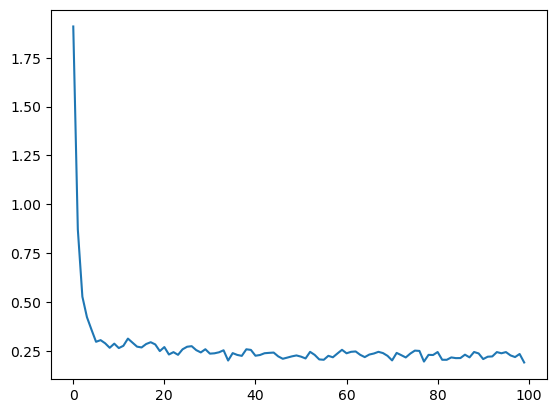

In [338]:
plt.plot(losses)
plt.show()

In [339]:
from matplotlib.animation import FuncAnimation

@torch.no_grad()
def sample(model, config, noise_scheduler):
    model.eval()
    sample = torch.randn(1, config.max_seq_len, 2).to(config.device)
    frames = [sample.cpu().numpy()[0]]
    ts = np.linspace(0, len(noise_scheduler)-1, len(noise_scheduler))[::-1]
    for t in ts:
        t_ = torch.full((1, config.max_seq_len), t).int().to(config.device)
        sample = noise_scheduler.revert(model(sample, t_.float()), t_[0, 0], sample)
        frames.append(sample.cpu().numpy()[0])
    return frames

def make_gif_one(frames, save_path):
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    axs = axs.flatten()
    for i in range(10):
        axs[i].set_xlim(-1, 1)
        axs[i].set_ylim(-1, 1)
        axs[i].set_aspect('equal')
        axs[i].set_title(f'Sample {i}')
        axs[i].xaxis.set_tick_params(labelbottom=False)
        axs[i].yaxis.set_tick_params(labelleft=False)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    scats = [axs[i].scatter(frames[0][i][:,0], frames[0][i][:,1], s=5, marker='s', alpha=0.2, c='black') for i in range(10)]
    def animate(i):
        i = i*5
        for j in range(10):
            scats[j].set_offsets(frames[j][i])
        return scats
    anim = FuncAnimation(fig, animate, frames=len(frames[0])//5 + 1, interval=100)
    anim.save(save_path, dpi=80, writer='imagemagick')
    plt.close()

In [340]:
frames = [sample(model, config, noise_scheduler) for _ in range(10)]

In [341]:
make_gif_one(frames, "static/nums_transformer.gif")

MovieWriter imagemagick unavailable; using Pillow instead.
